In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree # for tree.plot_tree()
from sklearn.tree import export_text # for export_text()

### Plot entropy for coin flip (Bernoulli trial) with probability p = P(heads) = P(success).

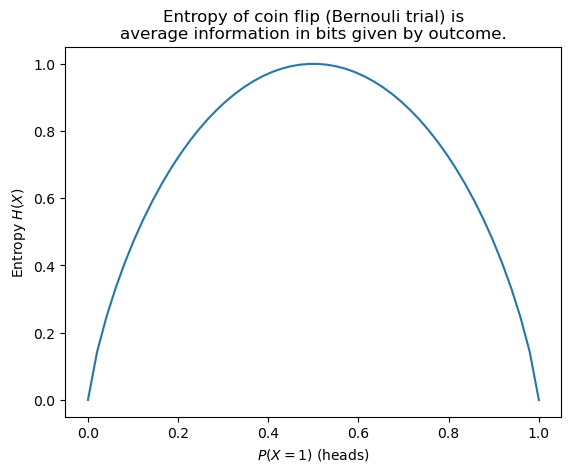

In [3]:
X = np.array([0, 1]) # We don't care about these values--only their number.
xplot = np.linspace(0, 1)
H_X = np.zeros(len(xplot))
for i in np.arange(0, len(xplot)):
    p = xplot[i]
    P = np.array([p, 1 - p])
    if (0 < p) & (p < 1):
        H_X[i] = -np.sum(P * np.log2(P))
    else:
        H_X[i] = 0

plt.plot(xplot, H_X)
plt.title('Entropy of coin flip (Bernouli trial) is\n' +
          'average information in bits given by outcome.')
plt.xlabel(f'$P(X = 1)$ (heads)')
_ = plt.ylabel(f'Entropy $H(X)$')


### Small example to start by hand and finish with scikit-learn:

In [5]:
df_all = pd.read_csv('http://www.stat.wisc.edu/~jgillett/451/data/mtcars.csv', index_col=0)
df = df_all.head(n=8)
df = df[['mpg', 'cyl', 'vs']]
df

,mpg,cyl,vs
Mazda RX4,21.0,6,0
Mazda RX4 Wag,21.0,6,0
Datsun 710,22.8,4,1
Hornet 4 Drive,21.4,6,1
Hornet Sportabout,18.7,8,0
Valiant,18.1,6,1
Duster 360,14.3,8,0
Merc 240D,24.4,4,1


Sorted by mpg:
                    mpg  cyl  vs
Duster 360         14.3    8   0
Valiant            18.1    6   1
Hornet Sportabout  18.7    8   0
Mazda RX4          21.0    6   0
Mazda RX4 Wag      21.0    6   0
Hornet 4 Drive     21.4    6   1
Datsun 710         22.8    4   1
Merc 240D          24.4    4   1

Sorted by cyl:
                    mpg  cyl  vs
Datsun 710         22.8    4   1
Merc 240D          24.4    4   1
Mazda RX4          21.0    6   0
Mazda RX4 Wag      21.0    6   0
Hornet 4 Drive     21.4    6   1
Valiant            18.1    6   1
Hornet Sportabout  18.7    8   0
Duster 360         14.3    8   0

|--- mpg <= 21.20
|   |--- mpg <= 18.40
|   |   |--- mpg <= 16.20
|   |   |   |--- class: 0
|   |   |--- mpg >  16.20
|   |   |   |--- class: 1
|   |--- mpg >  18.40
|   |   |--- class: 0
|--- mpg >  21.20
|   |--- class: 1

Accuracy on training data is clf.score(X, y)=1.0.


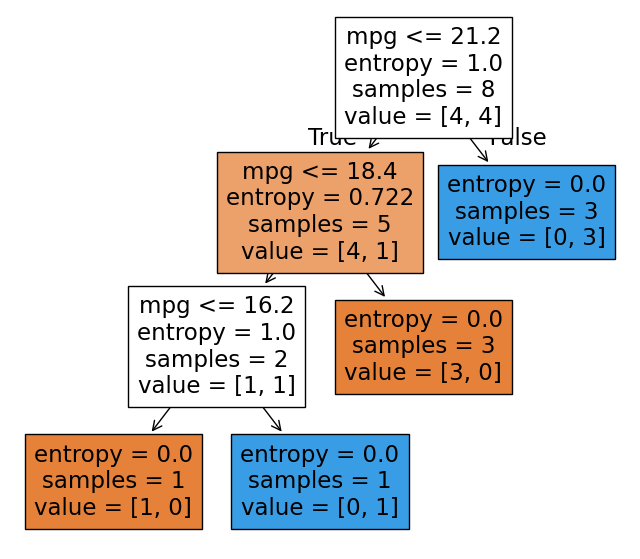

In [6]:
feature_names = ['mpg', 'cyl']
X = df[feature_names]
y = df.vs
print(f"Sorted by mpg:\n{df.sort_values('mpg')}\n")
print(f"Sorted by cyl:\n{df.sort_values('cyl')}\n")

clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
clf.fit(X, y)
plt.rcParams["figure.figsize"] = (8, 7) # (width, height) https://matplotlib.org/stable/api/figure_api.html
tree.plot_tree(clf, feature_names=feature_names, filled=True)
print(export_text(clf, feature_names=feature_names))
print(f'Accuracy on training data is clf.score(X, y)={clf.score(X, y)}.')

# Students: You do not have to learn the following code
that implements the ID3 algorithm; but I think it may be helpful
in understanding how ID3 works.

### Define helper functions:
 - f_ID3(y) to give average y value over nodes in S
 - I(p) to give information content corresponding to outcome probability p
 - H(S) to give entropy of S
 - H_weighted(S_minus, S_plus) to give weighted average entropy of the split
 - cost(y) is just a wrapper of H(S) for classification (see below for regression)
 - cost_of_split() is just a wrapper of H_weighted() for classification (see below for regression)


In [9]:
def f_ID3(y): # y is a vector of 0s and 1s; returns average y (for classificition, it is also proportion of 1s)
    return (1 / y.size) * np.sum(y)

def I(p): # p is the probability of an outcome
    return -np.log2(p)

def H(y): # y is a vector of 0s and 1s
    p = f_ID3(y)
    if (0 < p) & (p < 1):
        return p * I(p) + (1 - p) * I(1 - p)
    else:
        return 0.0 # otherwise format specifier ":.3" used elsewhere complains about integer 0

def H_weighted(y_minus, y_plus): # y_minus and y_plus are each vectors of 0s and 1s
    n_minus = y_minus.size
    n_plus = y_plus.size
    n = n_minus + n_plus
    return (n_minus / n) * H(y_minus) + (n_plus / n) * H(y_plus)

def cost(y):
    return H(y)

def cost_of_split(y_minus, y_plus):
    return H_weighted(y_minus, y_plus)


### Define function split(X, y, feature_names)
that gives the best feature to split on, the best threshold, and the minimum cost of that split.

In [11]:
def split(X, y, feature_names, debug=False):
    min_cost = np.Infinity
    best_j = np.NAN
    best_t = np.NAN
    if np.isclose(cost(y), 0): # instead of 'cost(y) == 0'
        return (best_j, best_t, min_cost)
    n_features = X.shape[1]
    assert n_features == len(feature_names)
    for j in range(n_features):
        feature = X.iloc[:, j]
        unique = np.unique(feature)
        if unique.size == 1: # cannot split on this feature
            continue
        thresholds = (unique[1:] + unique[:-1]) / 2 # averages each adjacent pair of unique values
        if debug:
            print(f'feature_names[{j}]={feature_names[j]}, unique={unique}, thresholds={thresholds}')
        for t in thresholds:
            S_minus = y[feature <=  t]
            S_plus  = y[feature > t]
            current_cost = cost_of_split(S_minus.to_numpy(), S_plus.to_numpy())
            if debug:
                print(f'    t={t:.3}, S_minus={S_minus}, S_plus={S_plus}, cost_minus={cost(S_minus):.3}, cost_plus={cost(S_plus):.3}, cost_split={cost:.3}')
            if current_cost < min_cost:
                min_cost = current_cost
                best_j = j
                best_t = t
    return (best_j, best_t, min_cost)

### Define recursive function decision_tree(X, y, feature_names, depth=0, debug=False)
that just returns on a zero-cost set S = (X, y) of examples but otherwise
calls split() to get the best split and then recursively calls decision_tree() on
each of the left and right splits.

In [13]:
def decision_tree(X, y, feature_names, depth=0, debug=False):
    # depth is of recursion for indenting output
    padding = ' ' * depth * 2 # indent output by depth * 2 spaces
    if debug:
        print(f'\n{padding}decision_tree(X and y: -------------------------------------------------------')
        display(pd.concat((X, y), axis=1))
    best_j, best_t, min_cost = split(X, y, feature_names, debug)
    if np.isnan(best_j): # split() did not find a split
        return
    print(f'{padding}best_j={best_j}, best_feature={feature_names[best_j]}, best_t={best_t:.3}, min_cost={min_cost:.3}')
    le = (X.iloc[:, best_j] <=  best_t) # 'le' refers to 'less than or equal to'
    decision_tree(X[ le], y[ le], feature_names, depth+1, debug=False) # left branch
    decision_tree(X[~le], y[~le], feature_names, depth+1, debug=False) # right branch


### Make the classification tree we started by hand earlier:

In [15]:
decision_tree(X, y, feature_names=feature_names)

best_j=0, best_feature=mpg, best_t=21.2, min_cost=0.451
  best_j=0, best_feature=mpg, best_t=18.4, min_cost=0.4
    best_j=0, best_feature=mpg, best_t=16.2, min_cost=0.0


Notice that these three splits are the same as those found by sci-kit learn, above.':

### Make a regression tree for y='mpg' vs x='wt' for the first 8 rows of 'mtcars':
 - cost(y) is a wrapper of mean_square() for regression (see above for classification)
 - cost_of_split() is gives sum of squared error associated with split for regression (see above for classification)


In [18]:
def mean_square(y):
    return np.sum((y - np.mean(y))**2) / y.size

def cost(y):
    assert y.size > 0
    return mean_square(y)

def cost_of_split(y_minus, y_plus):
    return cost(y_minus) * y_minus.size + cost(y_plus) * y_plus.size

df_all = pd.read_csv('http://www.stat.wisc.edu/~jgillett/451/data/mtcars.csv', index_col=0)
df = df_all.head(n=8)
feature_names = ['wt']
X = df[feature_names]
y = df.mpg

decision_tree(X, y, feature_names, debug=False)


best_j=0, best_feature=wt, best_t=3.33, min_cost=20.1
  best_j=0, best_feature=wt, best_t=3.03, min_cost=6.66
    best_j=0, best_feature=wt, best_t=2.47, min_cost=0.0
    best_j=0, best_feature=wt, best_t=3.2, min_cost=0.0
  best_j=0, best_feature=wt, best_t=3.51, min_cost=0.18
    best_j=0, best_feature=wt, best_t=3.45, min_cost=0.0


### Check our regression tree with DecisionTreeRegressor():

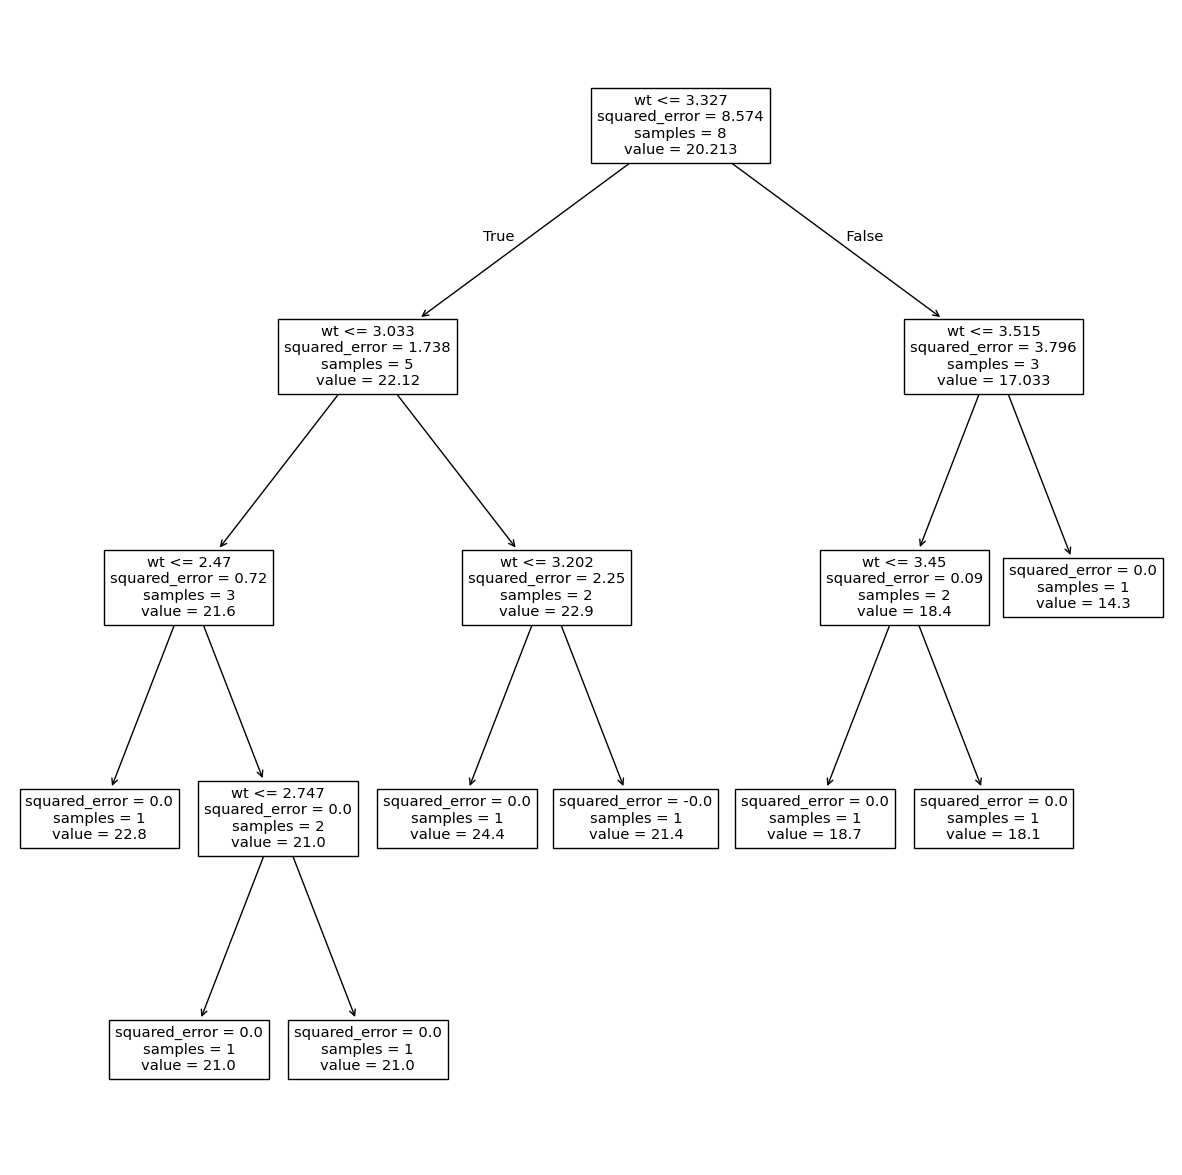

In [20]:
model = DecisionTreeRegressor(criterion='squared_error', max_depth=None)
model.fit(X, y)
fig = plt.figure(figsize=(15, 15)) # (width, height) in inches
_ = tree.plot_tree(model, feature_names=['wt'])


### Plot the regression function for y='mpg' vs x='wt' from all 32 rows of 'mtcars':
(Compare to earlier linear regression model.)


In [44]:
df = pd.read_csv('http://www.stat.wisc.edu/~jgillett/451/data/mtcars.csv', index_col=0)
X = df[['wt']]
y = df['mpg']
model = DecisionTreeRegressor(criterion='squared_error', max_depth=2) # try max_depth=None
model.fit(X, y)
y_hat = model.predict(X)
x = df.wt
plt.plot(x, y, '.', color='black', label='data')
plt.title('mtcars')
plt.xlabel('weight')
plt.ylabel('mpg')
plt.xlim(0, 6)
plt.ylim(0, 40)
x_plot = np.linspace(0, 6, num=100)
y_hat_plot = model.predict(pd.DataFrame({'wt': x_plot}))
plt.plot(x_plot, y_hat_plot, color='black', label=f'$\hat{{y}} = \bar{{y}}_S$ from tree')
# add vertical lines from (x, y) to (x, y_hat) to show errors:
plt.plot([x, x], [y, y_hat], # [x1, x2], [y1, y2]
         color='black', linewidth=.5, label=None) # label=None prevents duplicate legend entries
plt.plot([], [], color='black', linewidth=.5, label='errors') # add one legend entry
plt.plot(x, y_hat, '.', color='red', label='fitted values')
plt.legend()
print(f'model.score(X, y)={model.score(X, y):.3}')


<>:16: SyntaxWarning: invalid escape sequence '\h'
<>:16: SyntaxWarning: invalid escape sequence '\h'
C:\Users\leoxi\AppData\Local\Temp\ipykernel_13580\194709946.py:16: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(x_plot, y_hat_plot, color='black', label=f'$\hat{{y}} = \bar{{y}}_S$ from tree')


model.score(X, y)=0.831
Error in callback <function _draw_all_if_interactive at 0x000002527914A2A0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
$\hat{y} = ar{y}_S$ from tree
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$\hat{y} = ar{y}_S$ from tree
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 800x700 with 1 Axes>